In [1]:
## reset specific variables (replace regular_expression by the variables of interest)
#%reset_selective <regular_expression>

# reset all variables
%reset -f

In [3]:
## Importing libraries

from datetime import datetime, date, timedelta
from array import *
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from pylab import savefig
import seaborn as sns
import pandas as pd
import csv
import json
import datetime as dt
from pymongo import MongoClient
from mongoengine import *
%matplotlib inline



In [4]:
## Creating/Connecting Mongo DB instances

# Provide the mongodb atlas url to connect python to mongodb using pymongo
#CONNECTION_STRING = "mongodb+srv://<jgu>:<123>@<cluster-jgu>.mongodb.net/SMARTAttributesFilter"

connect(db='SMARTAttributesFilter', alias='SMARTAttributesFilter_alias')

connect(db='OverTimeSSDsFailures', alias='OverTimeSSDsFailures_alias')

connect(db='AllAppsSSDsFailures', alias='AllAppsSSDsFailures_alias')

connect(db='AllAppsSSDsLocation', alias='AllAppsSSDsLocation_alias')

connect(db='FailuresAppsLocation', alias='FailuresAppsLocation_alias')

connect(db='SMARTAtt_FailuresAppsLocation', alias='SMARTAtt_FailuresAppsLocation_alias')

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, read_preference=Primary(), uuidrepresentation=3)

In [5]:
## Setting document schema

# SMART attributes and disk information from the 2 years daily sampling dataset (500k disks)
class SMARTAtt(Document):
     disk_id = FloatField(required=False, default='0')
     timestamp = DateTimeField(required=False, default='0')
     model_x = StringField(required=False, default='0')
     r_sectors = FloatField(required=False, default='0')
     u_errors = FloatField(required=False, default='0')
     p_failedA = FloatField(required=False, default='0')
     p_failedB = FloatField(required=False, default='0')
     e_failedA = FloatField(required=False, default='0')
     e_failedB = FloatField(required=False, default='0')
     n_b_written = FloatField(required=False, default='0')
     n_b_read = FloatField(required=False, default='0')
     meta = {'db_alias': 'SMARTAttributesFilter_alias'}

# Failure time and disk information from the 2 years daily sampling dataset (500k disks)
class OverTimeSSDsFailures(Document):
     disk_id = FloatField(required=False, default='0')
     failure_time = DateTimeField(required=False, default='0')
     model_x = StringField(required=False, default='0')
     meta = {'db_alias': 'OverTimeSSDsFailures_alias'}

# Failure time and disk information (without model) from the full datset (1M disks)
class AllAppsSSDsFailures(Document):
     disk_id = FloatField(required=False, default='0')
     failure_time = DateTimeField(required=False, default='0')
     app = StringField(required=False, default='0')
     node_id = FloatField(required=False, default='0')
     rack_id = FloatField(required=False, default='0')
     machine_room_id = FloatField(required=False, default='0')
     meta = {'db_alias': 'AllAppsSSDsFailures_alias'}

# Apps and disks characteristics from the full dataset (1M disks)
class AllAppsSSDsLocation(Document):
     disk_id = FloatField(required=False, default='0')
     model_y = StringField(required=False, default='0')
     app = StringField(required=False, default='0')
     node_id = FloatField(required=False, default='0')
     rack_id = FloatField(required=False, default='0')
     slot_id = FloatField(required=False, default='0')
     meta = {'db_alias': 'AllAppsSSDsLocation_alias'}

# Merge of OverTimeSSDsFailures and AllAppsSSDsFailures documents
class FailuresAppsLocation(Document):
     disk_id = FloatField(required=False, default='0')
     failure_time = DateTimeField(required=False, default='0')
     model_x = StringField(required=False, default='0')
     model_y = StringField(required=False, default='0')
     app = StringField(required=False, default='0')
     node_id = FloatField(required=False, default='0')
     rack_id = FloatField(required=False, default='0')
     machine_room_id = FloatField(required=False, default='0')
     meta = {'db_alias': 'FailuresAppsLocation_alias'}

class SMARTAtt_FailuresAppsLocation(Document):
     smart_att = ReferenceField(SMARTAtt)
     failures_app_location = ReferenceField(FailuresAppsLocation)
     meta = {'db_alias': 'SMARTAtt_FailuresAppsLocation_alias'}

In [ ]:
# Closing the connection to the DB

#disconnect(alias='SMARTAttributesFilter_alias')

#disconnect(alias='FailuresAppsLocation_alias_alias')

#disconnect(alias='FailuresAppsLocation_alias_alias')

#disconnect(alias='SMARTAtt_FailuresAppsLocation_alias')

In [ ]:
### Some queries in Mongoengine

## Creating the object related to the whole collection
#failuresAppsLocationTeste = FailuresAppsLocation.objects()

## Collecting the applications
#apps = FailuresAppsLocation.objects().distinct("app")
#print(apps)

## Looping inside dcuments, which are filtered for the kind o app
#for app_c in apps:
#   dataPerApp = FailuresAppsLocation.objects(app=app_c).filter()
   #dataPerAppToList = list(dataPerApp)
   #dataPerAppDf = pd.DataFrame.from_dict(dataPerAppToList)
     
#   for doc in dataPerApp:
#      arrayForDataPerApp = np.append(arrayForDataPerApp, doc.to_json())

##The collection size
#len(failuresAppsLocationTeste)

## Query if you know something about the document
#testando = FailuresAppsLocation.objects(disk_id="33722").get()

## Query if you know something about the document
#SMARTAttributesTest = SMARTAtt.objects(timestamp="2019-12-31").filter().limit(20)
#SMARTAttributesTest = SMARTAtt.objects(timestamp="2019-12-31").filter()

## Printing
#for i in SMARTAttributesTest:
#    print(i.timestamp)
    
## Deleting all collection
#failuresAppsLocationTeste.delete() 
  
##Deleting all collection using for loop
#for i in failuresAppsLocationTeste:
 # i.delete()

In [ ]:
### Some queries pandas

## Find an specific line based on a specific value from a column
#df_failuresLocationDocumentsJsonMTTF.loc[df_failuresLocationDocumentsJsonMTTF["mtff_node"] == 2] 
#d1 = data[data["City"] == "Houston"]
#dataFrame.Reg_Price[i]

## Ploting very basic graphs
#df.groupby('Sex').sum().plot(kind='bar');
#print(df_app)
#df_appNode.groupby(['app']).plot(kind='bar')
#df.groupby(['Sex', 'Survived'] )['Survived'].count().plot.bar(figsize=(8, 6));

In [6]:
# Querying/Reading the OverTimeSSDsFailures database (mongodb) and turning It into a pandas dataframe

doc_AlibabaOver_Failurelogs = OverTimeSSDsFailures.objects()

jSon_AlibabaOver_Failurelogs = json.loads(doc_AlibabaOver_Failurelogs.to_json())
df_AlibabaOver_Failurelogs = pd.DataFrame.from_dict(jSon_AlibabaOver_Failurelogs) 

# Modifying the mongo db date type to some human-readable type
dicDateToString = json.dumps(list(df_AlibabaOver_Failurelogs['failure_time']))
dicStringToJson = json.loads(dicDateToString)
dicJsonToDf = pd.DataFrame.from_dict(dicStringToJson)
df_AlibabaOver_Failurelogs['failure_time'] = dicJsonToDf['$date']

In [7]:
# Querying/Reading the AllAppsSSDsFailures database (mongodb) and turning It into a pandas dataframe

doc_AlibabaSnapShot_FailuresAppsLocation = AllAppsSSDsFailures.objects()

jSon_AlibabaSnapShot_FailuresAppsLocation = json.loads(doc_AlibabaSnapShot_FailuresAppsLocation.to_json())
df_AlibabaSnapShot_FailuresAppsLocation = pd.DataFrame.from_dict(jSon_AlibabaSnapShot_FailuresAppsLocation) 

# Modifying the mongo db date type to some human-readable type
dicDateToString = json.dumps(list(df_AlibabaSnapShot_FailuresAppsLocation['failure_time']))
dicStringToJson = json.loads(dicDateToString)
dicJsonToDf = pd.DataFrame.from_dict(dicStringToJson)
df_AlibabaSnapShot_FailuresAppsLocation['failure_time'] = dicJsonToDf['$date']

In [8]:
# Querying/Reading the AllAppsSSDsLocation database (mongodb)

doc_AlibabaSnapShot_AllAppsSSDsLocation = AllAppsSSDsLocation.objects()

jSon_AlibabaSnapShot_AllAppsSSDsLocation = json.loads(doc_AlibabaSnapShot_AllAppsSSDsLocation.to_json())
df_AlibabaSnapShot_AllAppsSSDsLocation = pd.DataFrame.from_dict(jSon_AlibabaSnapShot_AllAppsSSDsLocation) 

In [9]:
# Querying/Reading the FailuresAppsLocation database (mongodb) and turning It into a pandas dataframe - DB which merges both failures dataset

doc_MergeDs_FailuresAppsLocation = FailuresAppsLocation.objects()

jSon_MergeDs_FailuresAppsLocation = json.loads(doc_MergeDs_FailuresAppsLocation.to_json())
df_MergeDs_FailuresAppsLocation = pd.DataFrame.from_dict(jSon_MergeDs_FailuresAppsLocation) 

# Modifying the mongo db date type to some human-readable type
dicDateToString = json.dumps(list(df_MergeDs_FailuresAppsLocation['failure_time']))
dicStringToJson = json.loads(dicDateToString)
dicJsonToDf = pd.DataFrame.from_dict(dicStringToJson)
df_MergeDs_FailuresAppsLocation['failure_time'] = dicJsonToDf['$date']

In [10]:
## Converting failure time columns to hours (for SSDs in common dataset)

# creating a temporary variable to be used to calculate the general mttf equation approach
df_genMTTF_MergeDs_FailuresAppsLocation = df_MergeDs_FailuresAppsLocation

## Value representing: 2018-01-01 00:00:00 (starting date from the experiment)
#1514764800000

#Subctracting by the initial time of the experiment and turning into hours
df_genMTTF_MergeDs_FailuresAppsLocation['failure_time'] = df_MergeDs_FailuresAppsLocation.failure_time.sub(1514764800000)
df_genMTTF_MergeDs_FailuresAppsLocation['failure_time'] = df_MergeDs_FailuresAppsLocation.failure_time.div(1000)
df_genMTTF_MergeDs_FailuresAppsLocation['failure_time'] = df_MergeDs_FailuresAppsLocation.failure_time.div(60)
df_genMTTF_MergeDs_FailuresAppsLocation['failure_time'] = df_MergeDs_FailuresAppsLocation.failure_time.div(60)
#df_failuresLocationDocumentsJsonMTTF.head(3)

In [11]:
## Converting failure time columns to hours (for All failed SSDs dataset)

#Subctracting by the initial time of the experiment and turning into hours
df_AlibabaSnapShot_FailuresAppsLocation['failure_time'] = df_AlibabaSnapShot_FailuresAppsLocation.failure_time.sub(1514764800000)
df_AlibabaSnapShot_FailuresAppsLocation['failure_time'] = df_AlibabaSnapShot_FailuresAppsLocation.failure_time.div(1000)
df_AlibabaSnapShot_FailuresAppsLocation['failure_time'] = df_AlibabaSnapShot_FailuresAppsLocation.failure_time.div(60)
df_AlibabaSnapShot_FailuresAppsLocation['failure_time'] = df_AlibabaSnapShot_FailuresAppsLocation.failure_time.div(60)
#df_AlibabaSnapShot_FailuresAppsLocation.head()

In [13]:
## Calculating MTTF (general equation) per node, rack and general using failed SSDs in common

# Unique values by column
id_apps = df_genMTTF_MergeDs_FailuresAppsLocation.app.unique()
#id_nodes = df_failuresLocationDocumentsJsonMTTF.node_id.unique()
#id_racks = nodes = df_failuresLocationDocumentsJsonMTTF.rack_id.unique()
#id_ssds = nodes = df_failuresLocationDocumentsJsonMTTF.disk_id.unique()

#Calculating the MTTFs
#df_general = df_failuresLocationDocumentsJsonMTTF['failure_time'].mean()
df_appNode = df_genMTTF_MergeDs_FailuresAppsLocation.groupby(['app', 'node_id'])['failure_time'].mean()
df_appNode = pd.DataFrame(df_appNode)
df_appNode.rename(columns = {'failure_time':'mttf_appNode'}, inplace=True)
df_appRack = df_genMTTF_MergeDs_FailuresAppsLocation.groupby(['app', 'rack_id'])['failure_time'].mean()
df_appRack = pd.DataFrame(df_appRack)
df_appRack.rename(columns = {'failure_time':'mttf_appRack'}, inplace=True)
df_app = df_genMTTF_MergeDs_FailuresAppsLocation.groupby(['app'])['failure_time'].mean()
df_app = pd.DataFrame(df_app)
df_app.rename(columns = {'failure_time':'mttf_app'}, inplace=True)
#df_all = df_failuresLocationDocumentsJsonMTTF.groupby(['app', 'rack_id', 'node_id'])['failure_time'].mean()

# Merging the results with the original dataframe
df_result = pd.merge(df_genMTTF_MergeDs_FailuresAppsLocation, df_appNode, how='left', on=['app', 'node_id'])
df_result = pd.merge(df_result, df_appRack, how='left', on=['app', 'rack_id'])
df_result = pd.merge(df_result, df_app, how='left', on=['app'])

# Selecting the columns of interest
df_resultFiltered = df_result.loc[:,['app','node_id', 'rack_id','mttf_appNode','mttf_appRack','mttf_app']]
#df_resultFiltered.to_csv('failuresLocationApp.csv')

In [55]:
df_result.head()

,_id,disk_id,failure_time,model_x,model_y,app,node_id,rack_id,machine_room_id,mttf_appNode,mttf_appRack,mttf_app
0,{'$oid': '6266c2e8718b63c8dff976fb'},33722.0,43.258889,MA2,A2,RM,66688.0,11488.0,455.0,43.258889,2731.489028,9314.031077
1,{'$oid': '6266c2e8718b63c8dff976fc'},58337.0,46.754444,MA2,A2,RM,114833.0,9859.0,455.0,46.754444,46.754444,9314.031077
2,{'$oid': '6266c2e8718b63c8dff976fd'},26378.0,51.395556,MA1,A3,none,145735.0,6860.0,127.0,4203.318264,4534.032191,9568.609801
3,{'$oid': '6266c2e8718b63c8dff976fe'},39876.0,51.490833,MA1,A3,RM,217964.0,17596.0,92.0,51.490833,2603.324954,9314.031077
4,{'$oid': '6266c2e8718b63c8dff976ff'},199348.0,53.050833,MC1,C1,NAS,237451.0,22765.0,137.0,53.050833,7399.522222,11613.122213


In [14]:
### To investigate the SSDs by application

exp_years = 2
exp_months = 12*exp_years
hours_per_year = 365*24
id_apps = df_AlibabaSnapShot_AllAppsSSDsLocation.app.unique()


#Creating a dataframe to generate some statistics taking into account the application which is running
df_idApps = pd.DataFrame(id_apps, columns=["app"])
#Adding empty colums
df_idAppsSSDs = pd.DataFrame(df_idApps, columns=["app", "N_AllSSDsApp", "N_failed_SDDs",  "AFR_SDDs", "mttf_SDDs", "AFR_SDDs_total", "mttf_SDDs_total", "N_failed_CommonSDDs",  "AFR_CommonSDDs", "mttf_CommonSDDs","AFR_CommonSDDs_total", "mttf_CommonSDDs_total"])


for i in id_apps:
    #Looping the AlibabaSnapshot_AllAppsSSDsLocation DB in order to count the total of ssds by application    
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_AllSSDsApp'] = df_AlibabaSnapShot_AllAppsSSDsLocation.loc[(df_AlibabaSnapShot_AllAppsSSDsLocation['app']) == i]['disk_id'].count()
    
    #Looping the FailuresAppsLocation (merged dss) in order to count the number of failed ssds by application    
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_failed_CommonSDDs'] = df_MergeDs_FailuresAppsLocation.loc[(df_MergeDs_FailuresAppsLocation['app']) == i]['disk_id'].count()
    #Looping the AllAppsSSDsFailures DB in order to count the number of failed ssds by application    
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_failed_SDDs'] = df_AlibabaSnapShot_FailuresAppsLocation.loc[(df_AlibabaSnapShot_FailuresAppsLocation['app']) == i]['disk_id'].count()
    
    # Calculating specific (failedSSDsperApp/TotalSSDsperAPP) app AFR and MTTF using failed ssds from the Alibaba Snapshot database (AllAppsSSDsFailures)
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_SDDs'] = ((df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_failed_SDDs'])*(12/exp_months))/(df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_AllSSDsApp'])
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'mttf_SDDs'] = (hours_per_year)/(df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_SDDs'])
    # Calculating specific (failedSSDsCommonperApp/TotalSSDsCommonperApp) app AFR and MTTF using failed ssds in common to the Snapshot and Overtime databases (FailuresAppsLocation)
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_CommonSDDs'] = ((df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_failed_CommonSDDs'])*(12/exp_months))/(df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_AllSSDsApp'])
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'mttf_CommonSDDs'] = (hours_per_year)/(df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_CommonSDDs'])
    
for i in id_apps:
    # Calculating total (failedSSDsperApp/TotalSSDsExperiment) AFR and MTTF using failed ssds from the Alibaba Snapshot database (AllAppsSSDsFailures)
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_SDDs_total'] = ((df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_failed_SDDs'])*(12/exp_months))/(df_idAppsSSDs.N_AllSSDsApp.sum())
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'mttf_SDDs_total'] = (hours_per_year)/(df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_SDDs_total'])
    # Calculating total (failedSSDsCommonperApp/TotalSSDsExperiment) AFR and MTTF using failed ssds in common to the Snapshot and Overtime databases (FailuresAppsLocation)
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_CommonSDDs_total'] = ((df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'N_failed_CommonSDDs'])*(12/exp_months))/(df_idAppsSSDs.N_AllSSDsApp.sum())
    df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'mttf_CommonSDDs_total'] = (hours_per_year)/(df_idAppsSSDs.loc[(df_idAppsSSDs['app']) == i, 'AFR_CommonSDDs_total'])

#Merging mttf per app to include the MTTF (this calculated using the general MTTF equation - not storage's specific) column into the failed ssds by application dataframe
df_idAppsSSDsMTTF = pd.merge(df_idAppsSSDs, df_app, how='left', on=['app'])
#df_idAppsSSDsMTTF.head(20)

df_idAppsSSDs.head(20)


,app,N_AllSSDsApp,N_failed_SDDs,AFR_SDDs,mttf_SDDs,AFR_SDDs_total,mttf_SDDs_total,N_failed_CommonSDDs,AFR_CommonSDDs,mttf_CommonSDDs,AFR_CommonSDDs_total,mttf_CommonSDDs_total
0,WPS,44676.0,529.0,0.005920,1.479629e+06,0.000274,3.197632e+07,496.0,0.005551,1.578072e+06,0.000257,3.410378e+07
1,WSM,380170.0,8916.0,0.011726,7.470366e+05,0.004617,1.897204e+06,8161.0,0.010733,8.161473e+05,0.004226,2.072721e+06
2,RM,183981.0,3016.0,0.008196,1.068749e+06,0.001562,5.608578e+06,2602.0,0.007071,1.238796e+06,0.001347,6.500950e+06
3,none,248757.0,3552.0,0.007139,1.226977e+06,0.001839,4.762239e+06,2966.0,0.005962,1.469394e+06,0.001536,5.703126e+06
4,WS,17740.0,232.0,0.006539,1.339676e+06,0.000120,7.291152e+07,61.0,0.001719,5.095161e+06,0.000032,2.773028e+08
5,DB,26781.0,203.0,0.003790,2.311345e+06,0.000105,8.332745e+07,113.0,0.002110,4.152240e+06,0.000059,1.496944e+08
6,DAE,16000.0,1214.0,0.037937,2.309061e+05,0.000629,1.393367e+07,1214.0,0.037937,2.309061e+05,0.000629,1.393367e+07
7,SS,32936.0,184.0,0.002793,3.136080e+06,0.000095,9.193192e+07,151.0,0.002292,3.821448e+06,0.000078,1.120230e+08
8,NAS,14454.0,541.0,0.018715,4.680852e+05,0.000280,3.126705e+07,541.0,0.018715,4.680852e+05,0.000280,3.126705e+07


In [15]:
### To investigate the SDDs without app distinguishing

#Creating a data frame to calculate the AFR and MTTF without app distinguishing.
data = {'FailedSSDsSet':['FailedSSDs', 'FailedCommonSSDs']}
df_general_AFRMTTF = pd.DataFrame(data)
df_general_AFRMTTF = pd.DataFrame(df_general_AFRMTTF, columns=['FailedSSDsSet', 'AFR_General', 'MTTF_General'])

# Calculating general (failedSSDs/TotalSSDsExperiment) AFR and MTTF using failed ssds from the Alibaba Snapshot database (AllAppsSSDsFailures)
df_general_AFRMTTF.loc[(df_general_AFRMTTF['FailedSSDsSet']) == 'FailedSSDs', 'AFR_General'] = ((df_idAppsSSDs.N_failed_SDDs.sum())*(12/exp_months))/(df_idAppsSSDs.N_AllSSDsApp.sum())
df_general_AFRMTTF.loc[(df_general_AFRMTTF['FailedSSDsSet']) == 'FailedSSDs', 'MTTF_General'] = (hours_per_year)/(df_general_AFRMTTF.loc[(df_general_AFRMTTF['FailedSSDsSet']) == 'FailedSSDs', 'AFR_General'])
# Calculating general AFR and MTTF using failed ssds in common to the Snapshot and Overtime databases (FailuresAppsLocation)
df_general_AFRMTTF.loc[(df_general_AFRMTTF['FailedSSDsSet']) == 'FailedCommonSSDs', 'AFR_General'] = ((df_idAppsSSDs.N_failed_CommonSDDs.sum())*(12/exp_months))/(df_idAppsSSDs.N_AllSSDsApp.sum())
df_general_AFRMTTF.loc[(df_general_AFRMTTF['FailedSSDsSet']) == 'FailedCommonSSDs', 'MTTF_General'] = (hours_per_year)/(df_general_AFRMTTF.loc[(df_general_AFRMTTF['FailedSSDsSet']) == 'FailedCommonSSDs', 'AFR_General'])
df_general_AFRMTTF.head()
#df_idAppsSSDs.N_AllSSDsApp.sum()

,FailedSSDsSet,AFR_General,MTTF_General
0,FailedSSDs,0.009522,9.199691e+05
1,FailedCommonSSDs,0.008444,1.037441e+06


In [119]:
### To investigate the AFR and MTTF per SSD models for each application

exp_years = 2
exp_months = 12*exp_years
hours_per_year = 365*24
id_apps = df_AlibabaSnapShot_AllAppsSSDsLocation.app.unique()
id_models = df_AlibabaSnapShot_AllAppsSSDsLocation.model_y.unique()


df_MergeAlibabaAllandFailures =  pd.merge(df_AlibabaSnapShot_AllAppsSSDsLocation, df_AlibabaSnapShot_FailuresAppsLocation, how = 'inner', on = ['app', 'disk_id', 'node_id'])

df_idModelsSSDs = pd.DataFrame(columns=["app", "models", "N_AllSSDsApp", "N_failed_SDDs",  "AFR_SDDs", "mttf_SDDs"])

for j in id_models:
    for i in id_apps:
    
        #Looping the AlibabaSnapshot_AllAppsSSDsLocation DB in order to count the total of ssds/model by application    
        numberTotalSSDs = df_AlibabaSnapShot_AllAppsSSDsLocation.loc[(df_AlibabaSnapShot_AllAppsSSDsLocation.app.isin([i]) & df_AlibabaSnapShot_AllAppsSSDsLocation.model_y.isin([j])), "disk_id"].count()
        
        numberFailedSSDs = df_MergeAlibabaAllandFailures.loc[(df_MergeAlibabaAllandFailures.app.isin([i]) & df_MergeAlibabaAllandFailures.model_y.isin([j])), "disk_id"].count()

        if numberFailedSSDs != 0:
            AFR_SSDs = ((numberFailedSSDs)*(12/exp_months))/(numberTotalSSDs)
            MTTF_SSDs = (hours_per_year)/(AFR_SSDs)
        else: 
            AFR_SSDs = 0
            MTTF_SSDs = 0
        df_temp = pd.DataFrame(columns=["app", "models", "N_AllSSDsApp", "N_failed_SDDs",  "AFR_SDDs", "mttf_SDDs"])
        df_temp.loc[-1] = {'app' : i , 'models' : j, 'N_AllSSDsApp' : numberTotalSSDs, 'N_failed_SDDs': numberFailedSSDs, 'AFR_SDDs': AFR_SSDs, 'mttf_SDDs': MTTF_SSDs}
        df_idModelsSSDs = pd.concat([df_idModelsSSDs, df_temp], ignore_index=True)




In [ ]:
### To investigate the AFR and MTTF per SSD flash technology for each application

df_temp = df_idModelsSSDs.copy()
df_temp["tech"] = " "

df_temp.loc[(df_temp.models.isin(['A1']) | df_temp.models.isin(['A2']) | df_temp.models.isin(['A3']) | df_temp.models.isin(['A4']) | df_temp.models.isin(['A5']) | df_temp.models.isin(['A6']) | df_temp.models.isin(['B1']) | df_temp.models.isin(['B2']) | df_temp.models.isin(['B3'])), 'tech'] = 'MLC'
df_temp.loc[(df_temp.models.isin(['C1']) | df_temp.models.isin(['C2'])), 'tech'] = '3D-TLC'

df_temp1 = df_temp.groupby(['app', 'tech'], as_index=False)['N_failed_SDDs'].sum()
df_temp2 = df_temp.groupby(['app', 'tech'], as_index=False)['N_AllSSDsApp'].sum()
df_idTechSSDs = pd.merge(df_temp1, df_temp2, how='inner', on=['app', 'tech'])

df_idTechSSDs["AFR_SSDs"] = " "
df_idTechSSDs["mttf_SDDs"] = " "

for i in range(0, len(df_idTechSSDs)): 
    

    numberTotalSSDs = df_idTechSSDs.iloc[i].N_AllSSDsApp
    numberFailedSSDs = df_idTechSSDs.iloc[i].N_failed_SDDs
       
    if numberFailedSSDs != 0:
        AFR_SSDs = ((numberFailedSSDs)*(12/exp_months))/(numberTotalSSDs)
        MTTF_SSDs = (hours_per_year)/(AFR_SSDs)
    else: 
        AFR_SSDs = 0
        MTTF_SSDs = 0

    df_idTechSSDs.loc[i, 'AFR_SSDs'] = AFR_SSDs
    df_idTechSSDs.loc[i, 'mttf_SDDs'] = MTTF_SSDs

df_idTechSSDs.head(20)

In [ ]:
### To investigate the AFR and MTTF per SSD capacity for each application

df_temp = df_idModelsSSDs.copy()
df_temp["capacity"] = " "

df_temp.loc[(df_temp.models.isin(['A1']) | df_temp.models.isin(['A3']) | df_temp.models.isin(['A5']) | df_temp.models.isin(['B1'])), 'capacity'] = '480GB'
df_temp.loc[(df_temp.models.isin(['B2']) | df_temp.models.isin(['B3']) | df_temp.models.isin(['C1'])), 'capacity'] = '1920GB'
df_temp.loc[(df_temp.models.isin(['A2']) | df_temp.models.isin(['A6'])), 'capacity'] = '800GB'
df_temp.loc[(df_temp.models.isin(['A4'])), 'capacity'] = '240GB'
df_temp.loc[(df_temp.models.isin(['C2'])), 'capacity'] = '960GB'

df_temp1 = df_temp.groupby(['app', 'capacity'], as_index=False)['N_failed_SDDs'].sum()
df_temp2 = df_temp.groupby(['app', 'capacity'], as_index=False)['N_AllSSDsApp'].sum()
df_idCapacitySSDs = pd.merge(df_temp1, df_temp2, how='inner', on=['app', 'capacity'])

df_idCapacitySSDs["AFR_SSDs"] = " "
df_idCapacitySSDs["mttf_SDDs"] = " "

for i in range(0, len(df_idCapacitySSDs)): 
    

    numberTotalSSDs = df_idCapacitySSDs.iloc[i].N_AllSSDsApp
    numberFailedSSDs = df_idCapacitySSDs.iloc[i].N_failed_SDDs
       
    if numberFailedSSDs != 0:
        AFR_SSDs = ((numberFailedSSDs)*(12/exp_months))/(numberTotalSSDs)
        MTTF_SSDs = (hours_per_year)/(AFR_SSDs)
    else: 
        AFR_SSDs = 0
        MTTF_SSDs = 0

    df_idCapacitySSDs.loc[i, 'AFR_SSDs'] = AFR_SSDs
    df_idCapacitySSDs.loc[i, 'mttf_SDDs'] = MTTF_SSDs

df_idCapacitySSDs.head(20)

In [ ]:
### To investigate the AFR and MTTF per SSD lithography for each application

df_temp = df_idModelsSSDs.copy()
df_temp["lithography"] = " "

df_temp.loc[(df_temp.models.isin(['A1']) | df_temp.models.isin(['A2']) | df_temp.models.isin(['A3']) | df_temp.models.isin(['A6'])), 'lithography'] = '20nm'
df_temp.loc[(df_temp.models.isin(['A4']) | df_temp.models.isin(['A5'])), 'lithography'] = '16nm'
df_temp.loc[(df_temp.models.isin(['C1']) | df_temp.models.isin(['C2'])), 'lithography'] = 'V1'
df_temp.loc[(df_temp.models.isin(['B1'])), 'lithography'] = '21nm'
df_temp.loc[(df_temp.models.isin(['B2'])), 'lithography'] = '19nm'
df_temp.loc[(df_temp.models.isin(['B3'])), 'lithography'] = '24nm'

df_temp1 = df_temp.groupby(['app', 'lithography'], as_index=False)['N_failed_SDDs'].sum()
df_temp2 = df_temp.groupby(['app', 'lithography'], as_index=False)['N_AllSSDsApp'].sum()
df_idLitSSDs = pd.merge(df_temp1, df_temp2, how='inner', on=['app', 'lithography'])

df_idLitSSDs["AFR_SSDs"] = " "
df_idLitSSDs["mttf_SDDs"] = " "

for i in range(0, len(df_idLitSSDs)): 
    

    numberTotalSSDs = df_idLitSSDs.iloc[i].N_AllSSDsApp
    numberFailedSSDs = df_idLitSSDs.iloc[i].N_failed_SDDs
       
    if numberFailedSSDs != 0:
        AFR_SSDs = ((numberFailedSSDs)*(12/exp_months))/(numberTotalSSDs)
        MTTF_SSDs = (hours_per_year)/(AFR_SSDs)
    else: 
        AFR_SSDs = 0
        MTTF_SSDs = 0

    df_idLitSSDs.loc[i, 'AFR_SSDs'] = AFR_SSDs
    df_idLitSSDs.loc[i, 'mttf_SDDs'] = MTTF_SSDs

df_idLitSSDs.head(20)

### Plotting the AFRs and MTTFs per app - considering # ssds per app 

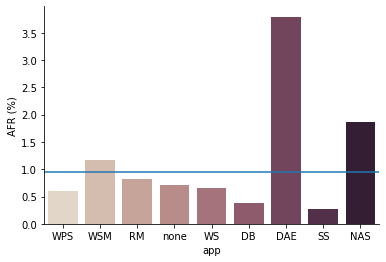

In [168]:
df_plotAFRMTTFSPF = df_idAppsSSDs.loc[:,['app','AFR_SDDs', 'mttf_SDDs']]

#df_plotAFRMTTFSPF = df_plotAFRMTTFSPF.assign(spf_all='spf_ssds')

df_plotAFRMTTFSPF["AFR_SDDs"] = df_plotAFRMTTFSPF["AFR_SDDs"]*100

graph = sns.barplot(x = "app", y = 'AFR_SDDs', palette = 'ch:.25', data = df_plotAFRMTTFSPF)
graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
#graph.set_ylabel("Gender",size = 67,color="g",alpha=0.5)
graph.set_ylabel("AFR (%)")
sns.despine()
plt.show()

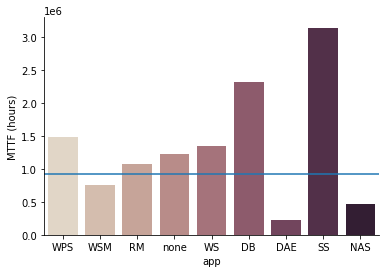

In [167]:
graph = sns.barplot(x = "app", y = 'mttf_SDDs', palette = 'ch:.25', data = df_plotAFRMTTFSPF)
graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'MTTF_General'].values[0])
graph.set_ylabel("MTTF (hours)")
sns.despine()
plt.show()

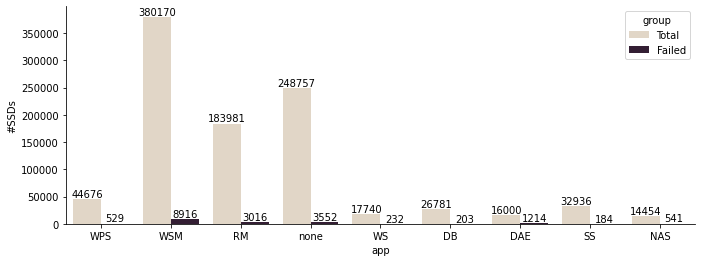

In [26]:
df_plotNSDDsFailedTotal1 = df_idAppsSSDs.loc[:,['app','N_AllSSDsApp']]
df_plotNSDDsFailedTotal2 = df_idAppsSSDs.loc[:,['app','N_failed_SDDs']]

df_plotNSDDsFailedTotal1 = df_plotNSDDsFailedTotal1.assign(group='Total')
df_plotNSDDsFailedTotal2 = df_plotNSDDsFailedTotal2.assign(group='Failed')
df_plotNSDDsFailedTotal2.rename(columns = {'N_failed_SDDs':'N_AllSSDsApp'}, inplace=True)

df_plotNSDDsFailedTotal1 = pd.concat([df_plotNSDDsFailedTotal1,df_plotNSDDsFailedTotal2])
#df_plotNSDDsFailedTotal1["N_AllSSDsApp"] = df_plotNSDDsFailedTotal1["N_AllSSDsApp"]

graph = sns.barplot(x = "app", y = 'N_AllSSDsApp', palette = 'ch:.25', hue = 'group', data = df_plotNSDDsFailedTotal1)
for container in graph.containers:
    graph.bar_label(container, label_type='edge')
graph.set_ylabel("#SSDs")
graph.figure.set_figwidth(11.27) # increasing the figure width
#graph.fig.set_figheight(11.7)
sns.despine()
plt.show()

#df_plotNSDDsFailedTotal1.head(20)

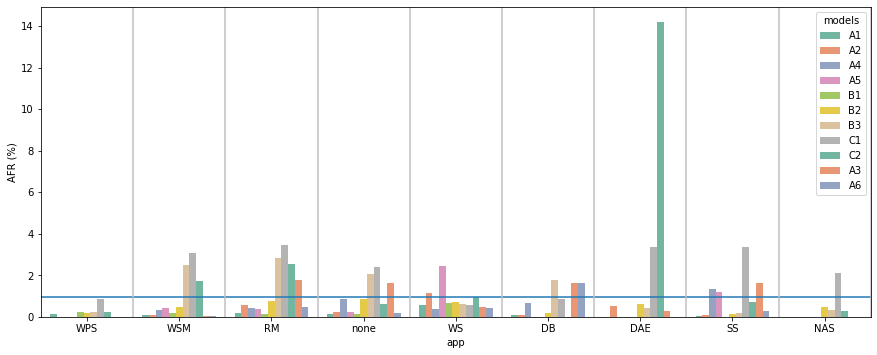

In [162]:
### To plot the AFR and MTTF per SSD models for each application

df_temp = df_idModelsSSDs.copy()
df_temp["AFR_SDDs"] = df_temp["AFR_SDDs"]*100

graph = sns.barplot(x = "app", y = 'AFR_SDDs', palette = 'Set2', hue = 'models', data = df_temp)
#for container in graph.containers:
#    graph.bar_label(container, label_type='edge')

graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
graph.set_ylabel("AFR (%)")
graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()



Text(0, 0.5, 'AFR (%)')

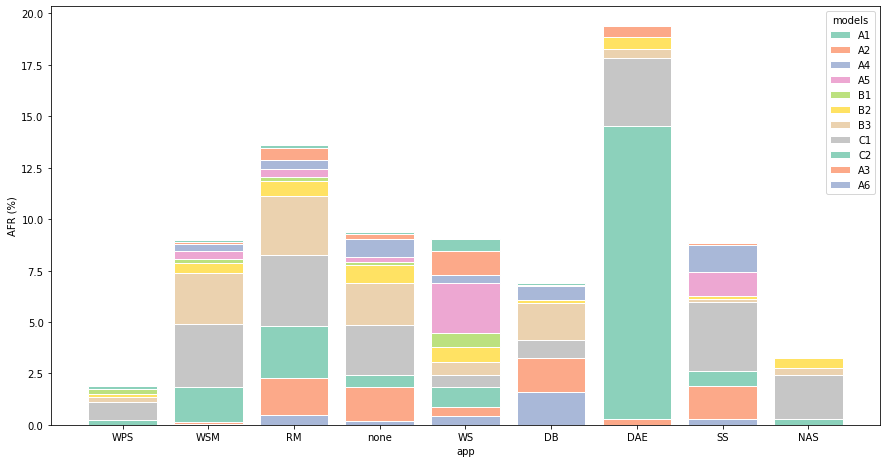

In [130]:
### To plot the AFR and MTTF per SSD models for each application

df_temp = df_idModelsSSDs.copy()
df_temp["AFR_SDDs"] = df_temp["AFR_SDDs"]*100

ax = sns.histplot(
    df_temp,
    x='app',
    # Use the value variable here to turn histogram counts into weighted
    # values.
    weights='AFR_SDDs',
    hue='models',
    multiple='stack',
    palette='Set2',
    # Add white borders to the bars.
    edgecolor='white',
    # Shrink the bars a bit so they don't touch.
    shrink=0.8
)
ax.figure.set_figwidth(14.87) # increasing the figure width
ax.figure.set_figheight(7.7)
#ax.set_title('Tips by Day and Gender')
# Remove 'Count' ylabel.
ax.set_ylabel("AFR (%)")

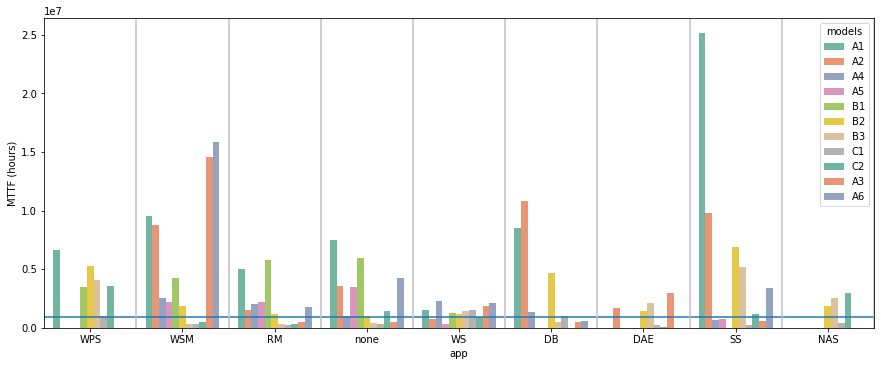

In [161]:
### To plot the AFR and MTTF per SSD models for each application

graph = sns.barplot(x = "app", y = 'mttf_SDDs', palette = 'Set2', hue = 'models', data = df_idModelsSSDs)
#for container in graph.containers:
#    graph.bar_label(container, label_type='edge')

graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'MTTF_General'].values[0])
graph.set_ylabel("MTTF (hours)")
graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

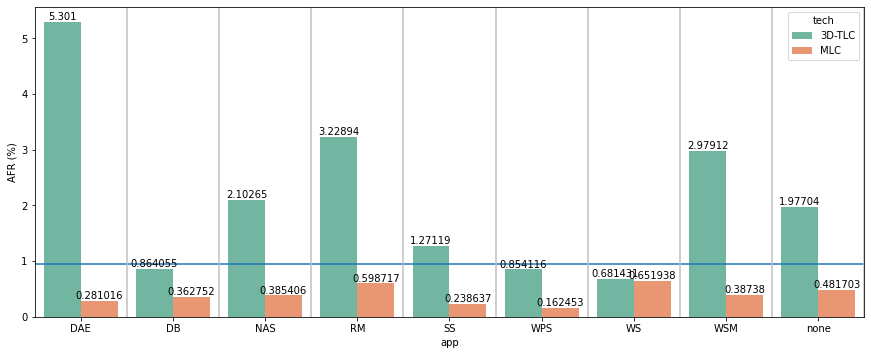

In [172]:
### To plot the AFR and MTTF per SSD flash technology for each application

df_temp3Plot = df_idTechSSDs.copy()
df_temp3Plot.loc[:, "AFR_SSDs"] = df_temp3Plot.loc[:, "AFR_SSDs"]*100
graph = sns.barplot(x = "app", y = 'AFR_SSDs', palette = 'Set2', hue = 'tech', data = df_temp3Plot)

for container in graph.containers:
    graph.bar_label(container, label_type='edge')


graph.set_ylabel("AFR (%)")
graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

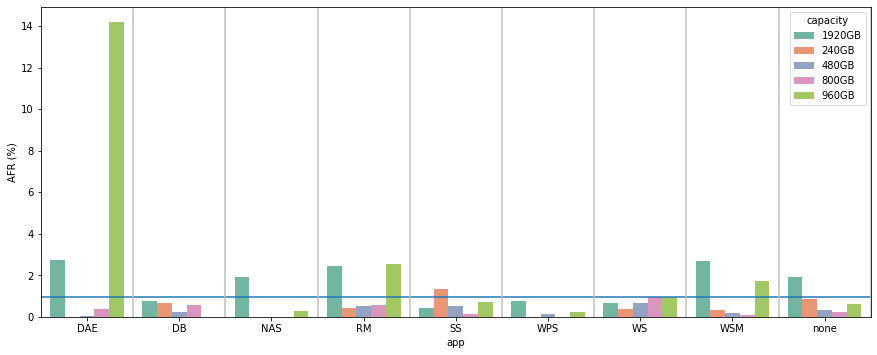

In [170]:
### To plot the AFR and MTTF per SSD flash capacity for each application

df_temp3Plot = df_idCapacitySSDs.copy()
df_temp3Plot.loc[:, "AFR_SSDs"] = df_temp3Plot.loc[:, "AFR_SSDs"]*100
graph = sns.barplot(x = "app", y = 'AFR_SSDs', palette = 'Set2', hue = 'capacity', data = df_temp3Plot)

#for container in graph.containers:
#    graph.bar_label(container, label_type='edge')


graph.set_ylabel("AFR (%)")
graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

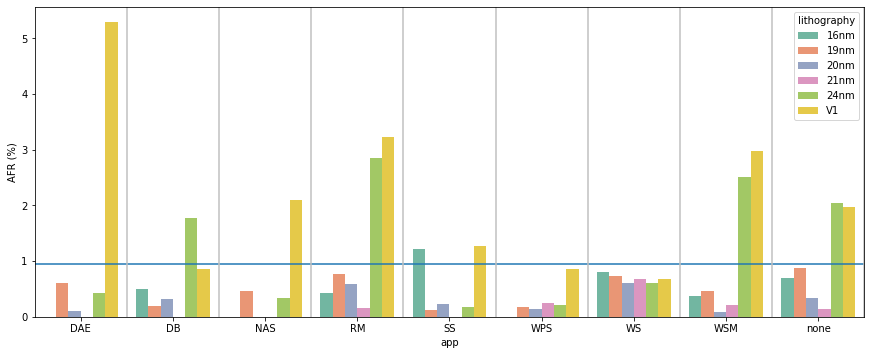

In [176]:
### To plot the AFR and MTTF per SSD flash lithography for each application

df_temp3Plot = df_idLitSSDs.copy()
df_temp3Plot.loc[:, "AFR_SSDs"] = df_temp3Plot.loc[:, "AFR_SSDs"]*100
graph = sns.barplot(x = "app", y = 'AFR_SSDs', palette = 'Set2', hue = 'lithography', data = df_temp3Plot)

#for container in graph.containers:
#    graph.bar_label(container, label_type='edge')


graph.set_ylabel("AFR (%)")
graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
graph.figure.set_figwidth(14.87) # increasing the figure width
graph.figure.set_figheight(5.7)
[graph.axvline(x+.5,color='silver') for x in graph.get_xticks()]
#sns.despine()
plt.show()

### Plotting the AFRs and MTTFs per app - considering # ssds per app and # all ssds in this experiment

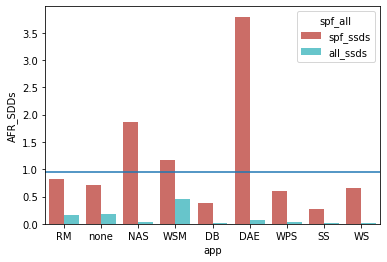

In [82]:
#Creating a data frame to rearrange both AFRs and MTTF columns - creating the categorie/column spf_all: spf (specific) tl (total)
df_plotAFRMTTFSPF = df_idAppsSSDs.loc[:,['app','AFR_SDDs', 'mttf_SDDs']]
df_plotAFRMTTFTL = df_idAppsSSDs.loc[:,['app','AFR_SDDs_total','mttf_SDDs_total']]

df_plotAFRMTTFSPF = df_plotAFRMTTFSPF.assign(spf_all='spf_ssds')
df_plotAFRMTTFTL = df_plotAFRMTTFTL.assign(spf_all='all_ssds')
df_plotAFRMTTFTL.rename(columns = {'AFR_SDDs_total':'AFR_SDDs', 'mttf_SDDs_total':'mttf_SDDs'}, inplace=True)

df_plotAFRMTTFSPFTL = pd.concat([df_plotAFRMTTFSPF, df_plotAFRMTTFTL])
df_plotAFRMTTFSPFTL["AFR_SDDs"] = df_plotAFRMTTFSPFTL["AFR_SDDs"]*100

graph = sns.barplot(x = "app", y = 'AFR_SDDs', palette = 'hls', hue = 'spf_all', data = df_plotAFRMTTFSPFTL)
graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'AFR_General'].values[0]*100)
plt.show()

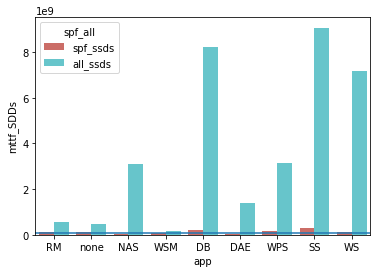

In [72]:
graph = sns.barplot(x = "app", y = 'mttf_SDDs', palette = 'hls', hue = 'spf_all', data = df_plotAFRMTTFSPFTL)
graph.axhline(df_general_AFRMTTF.loc[df_general_AFRMTTF['FailedSSDsSet'] == 'FailedSSDs', 'MTTF_General'].values[0])
plt.show()

In [397]:
## Saving sorted failure time per app into csv to be used for probability distribution fitting (All failed SDDs)

for i in id_apps:
    
    df_alibabasnapshot_toFitting = df_AlibabaSnapShot_FailuresAppsLocation.loc[df_AlibabaSnapShot_FailuresAppsLocation["app"] == i, "failure_time"]
    df_alibabasnapshot_toFitting.sort_values
    df_alibabasnapshot_toFitting.to_csv('Snapshot_FailureTimesApp' + i + '.csv', header=None, index=None)

df_alibabasnapshot_toFitting = df_AlibabaSnapShot_FailuresAppsLocation['failure_time']
df_alibabasnapshot_toFitting.to_csv('Snapshot_FailureTimesApp' + 'All' + '.csv', header=None, index=None)

In [393]:
## Saving sorted failure time per app into csv to be used for probability distribution fitting (SSDs in common)

for i in id_apps:
    
    df_merge_toFitting_times = df_genMTTF_MergeDs_FailuresAppsLocation.loc[df_genMTTF_MergeDs_FailuresAppsLocation["app"] == i, "failure_time"]
    df_merge_toFitting_times.sort_values
    df_merge_toFitting_times.to_csv('MergeSSDs_FailureTimesApp' + i + '.csv', header=None, index=None)

In [24]:
# Investigating Flash technology (using general mttf equation approach)

flashtech = pd.DataFrame({
'model_y':['A3', 'A2', 'B3' , 'B2', 'C1', 'C2'],  
'flash': ['MLC', 'MLC', 'MLC' , 'MLC', '3D-TLC', '3D-TLC']})

df_flashtech = pd.merge(df_result, flashtech, how='left', on=['model_y'])

df_flashtech = df_flashtech.groupby(['app','flash'])['failure_time'].mean()

df_flashtech = pd.DataFrame(df_flashtech)

df_flashtech.rename(columns = {'failure_time':'mttf_flash'}, inplace=True)

df_flashtech.to_csv('flashtech.csv')
#df_flashtech.head()


In [28]:
# Investigating Capacity (using general mttf equation approach)

capacity = pd.DataFrame({
'model_y':['A3', 'A2', 'B3' , 'B2', 'C1', 'C2'],  
'capacity': ['480GB', '800GB', '1920GB' , '1920GB', '1920GB', '960GB']})

df_capacity = pd.merge(df_result, capacity, how='left', on=['model_y'])

df_capacity = df_capacity.groupby(['app','capacity'])['failure_time'].mean()

df_capacity = pd.DataFrame(df_capacity)

df_capacity.rename(columns = {'failure_time':'mttf_capacity'}, inplace=True)

df_capacity.to_csv('capacity.csv')
#df_capacity.head(50)

In [ ]:
##  Creating Graphs (cell still in progress)

fig = sns.catplot(x="app", y="failure_time", hue="model_x", data=df_failuresLocationDocumentsJson,
               row="node_id", col="rack_id", kind="bar", ci=90, palette="Blues_d", aspect=0.9, height=4.5
                  , legend_out = True, margin_titles = True)

fig.set_axis_labels("App", "MTTF")
fig.set_xticklabels(["DAE", "DB", "NAS", "RM", "SS", "WPS", "WS", "WSM", "none"])

plt.savefig('teste.pdf', dpi=1200)

In [ ]:
# Querying/Reading the SMARTAtt database (mongodb) filtering by a specific SSD (all cells below still in progress)

smartDocuments = SMARTAtt.objects(disk_id="19015").filter()

jSon_smartDocumentsJson = json.loads(smartDocuments.to_json())
df_smartDocumentsJson = pd.DataFrame.from_dict(jSon_smartDocumentsJson) 

df_smartDocumentsJson.head()

In [ ]:
smartDocumentsDB = SMARTAtt.objects(disk_id="95341").filter()

jSon_smartDocumentsDBJson = json.loads(smartDocumentsDB.to_json())
df_smartDocumentsDBJson = pd.DataFrame.from_dict(jSon_smartDocumentsDBJson) 

df_smartDocumentsDBJson.head()

In [ ]:
smartDocumentsNAS = SMARTAtt.objects(disk_id="18144").filter()

jSon_smartDocumentsNASJson = json.loads(smartDocumentsNAS.to_json())
df_smartDocumentsNASJson = pd.DataFrame.from_dict(jSon_smartDocumentsNASJson) 

df_smartDocumentsNASJson.head()

In [ ]:
smartDocumentsRM = SMARTAtt.objects(disk_id="99516").filter()

jSon_smartDocumentsRMJson = json.loads(smartDocumentsRM.to_json())
df_smartDocumentsRMJson = pd.DataFrame.from_dict(jSon_smartDocumentsRMJson) 

df_smartDocumentsRMJson.head()

In [ ]:
smartDocumentsSS = SMARTAtt.objects(disk_id="199807").filter()

jSon_smartDocumentsSSJson = json.loads(smartDocumentsSS.to_json())
df_smartDocumentsSSJson = pd.DataFrame.from_dict(jSon_smartDocumentsSSJson) 

df_smartDocumentsSSJson.head()

In [ ]:
smartDocumentsWPS = SMARTAtt.objects(disk_id="30010").filter()

jSon_smartDocumentsWPSJson = json.loads(smartDocumentsWPS.to_json())
df_smartDocumentsWPSJson = pd.DataFrame.from_dict(jSon_smartDocumentsWPSJson) 

df_smartDocumentsWPSJson.head()

In [ ]:
smartDocumentsWS = SMARTAtt.objects(disk_id="17304").filter()

jSon_smartDocumentsWSJson = json.loads(smartDocumentsWS.to_json())
df_smartDocumentsWSJson = pd.DataFrame.from_dict(jSon_smartDocumentsWSJson) 

df_smartDocumentsWSJson.head()

In [ ]:
smartDocumentsWSM = SMARTAtt.objects(disk_id="29755").filter()

jSon_smartDocumentsWSMJson = json.loads(smartDocumentsWSM.to_json())
df_smartDocumentsWSMJson = pd.DataFrame.from_dict(jSon_smartDocumentsWSMJson) 

df_smartDocumentsWSMJson.head()

In [ ]:
smartDocumentsnone = SMARTAtt.objects(disk_id="12463").filter()

jSon_smartDocumentsnoneJson = json.loads(smartDocumentsnone.to_json())
df_smartDocumentsnoneJson = pd.DataFrame.from_dict(jSon_smartDocumentsnoneJson) 

df_smartDocumentsnoneJson.head()

In [100]:
#Mergin all smart attributes dataframes
df_smartDocumentsTotal = pd.concat([df_smartDocumentsJson, df_smartDocumentsDBJson, df_smartDocumentsNASJson, df_smartDocumentsRMJson, df_smartDocumentsSSJson, df_smartDocumentsWPSJson, df_smartDocumentsWSJson, df_smartDocumentsWSMJson, df_smartDocumentsnoneJson])

In [105]:
# Selecting the columns of interest
df_smartDocumentsTotalFiltered = df_smartDocumentsTotal.loc[:,['disk_id', 'timestamp' , 'r_sectors', 'u_errors','n_b_written','n_b_read']]

dicDateToString = json.dumps(list(df_smartDocumentsTotalFiltered['timestamp']))
dicStringToJson = json.loads(dicDateToString)
dicJsonToDf = pd.DataFrame.from_dict(dicStringToJson)
df_smartDocumentsTotalFiltered['timestamp'] = dicJsonToDf['$date']

#Subctracting by the initial time of the experiment and turning into hours
df_smartDocumentsTotalFiltered['timestamp'] = df_smartDocumentsTotalFiltered.timestamp.sub(1514764800000)
df_smartDocumentsTotalFiltered['timestamp'] = df_smartDocumentsTotalFiltered.timestamp.div(1000)
df_smartDocumentsTotalFiltered['timestamp'] = df_smartDocumentsTotalFiltered.timestamp.div(60)

# Relating to the correspodent app
appAtt = pd.DataFrame({
'disk_id':[19015, 95341, 18144 , 99516, 199807, 30010, 17304, 29755, 12463],  
'app': ['DAE', 'DB', 'NAS', 'RM', 'SS', 'WPS', 'WS', 'WSM', 'none']})

df_smartDocumentsTotalFiltered = pd.merge(df_smartDocumentsTotalFiltered, appAtt, how='left', on=['disk_id'])

df_smartDocumentsTotalFiltered.to_csv('smartattributesanalysisMinutesApp.csv')
#df_smartDocumentsTotalFiltered.tail(10)

In [ ]:
df_smartDocumentsTotalFiltered.head()

In [318]:
df_failuresLocationDocumentsJson.to_csv('failuresLocation.csv', index = None, header=True)